# Visualization

The resulting visualization will show two UMAP plots:
	•	Original cell types from ```celltype```. This is from the ground truth
	•	Predicted cell types from ```predictions```.

In [42]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
projectDir = Path(f"/tscc/nfs/home/s5srinivasan/scgpt-project/scGPT-ucsd-fork")
dataDir = Path(f"/tscc/nfs/home/s5srinivasan/scratch")

# Load .h5ad file
wilkData = sc.read_h5ad(dataDir / "predictionsWilk.h5ad")

In [10]:
wilkData.obs[["celltype", "predictions"]]

,celltype,predictions
560_cell.588_AGTTGGAGAACG_1,CD14+ Monocytes,CD14+ Monocytes
560_cell.637_TTGACACATACC_1,CD14+ Monocytes,Megakaryocytes
560_cell.639_CACCATAAGAAT_1,Low-density neutrophils,Megakaryocytes
560_cell.647_TTGTGAAACAGT_1,CD14+ Monocytes,CD14+ Monocytes
560_cell.652_CTAAGTTGCTTT_1,CD4+ T cells,CD4+ T cells
...,...,...
GSM4557339_HIP045_cell.2533_ACAAAACGCTAA_1,Myeloid dendritic cells,CD14+ Monocytes
GSM4557339_HIP045_cell.2534_AACCCGCTGGTC_1,CD8+ T cells,CD8+ T cells
GSM4557339_HIP045_cell.2535_GAACGCCAGACG_1,CD14+ Monocytes,CD14+ Monocytes
GSM4557339_HIP045_cell.2536_TCTAGGACTTTG_1,CD14+ Monocytes,Intermediate monocytes


In [6]:
wilkData.uns

OrderedDict()

In [7]:
wilkData.obsm

AxisArrays with keys: 

# Nearest neighbor graph constuction and visualization

1.	Compute PCA: UMAP requires a reduced representation of the data. ```sc.tl.pca``` computes principal components (default: 50 PCs).
2.	Compute Neighbors: ```sc.pp.neighbors``` calculates a neighborhood graph based on PCA-reduced data. This is required before running UMAP.
3.	Compute UMAP: ```sc.tl.umap``` generates UMAP embeddings using the neighbors graph.
4.	Sanity Checking Columns: Ensure the celltype and predictions columns exist before proceeding.



In [11]:
if 'X_umap' not in wilkData.obsm: # Check if UMAP embeddings are present - NOT PRESENT 
    if 'neighbors' not in wilkData.uns:  # Check if neighbors are already computed - NOT PRESENT
        
        # Compute neighbors using PCA (default)
        sc.tl.pca(wilkData)  # Compute PCA if not already done
        sc.pp.neighbors(wilkData)  # Compute neighbors
        
    # Compute UMAP
    sc.tl.umap(wilkData)

# Ensure the two columns exist in wilkData.obs
if 'celltype' not in wilkData.obs or 'predictions' not in wilkData.obs:
    raise ValueError("The specified columns 'celltype' and 'predictions' do not exist in wilkData.obs")

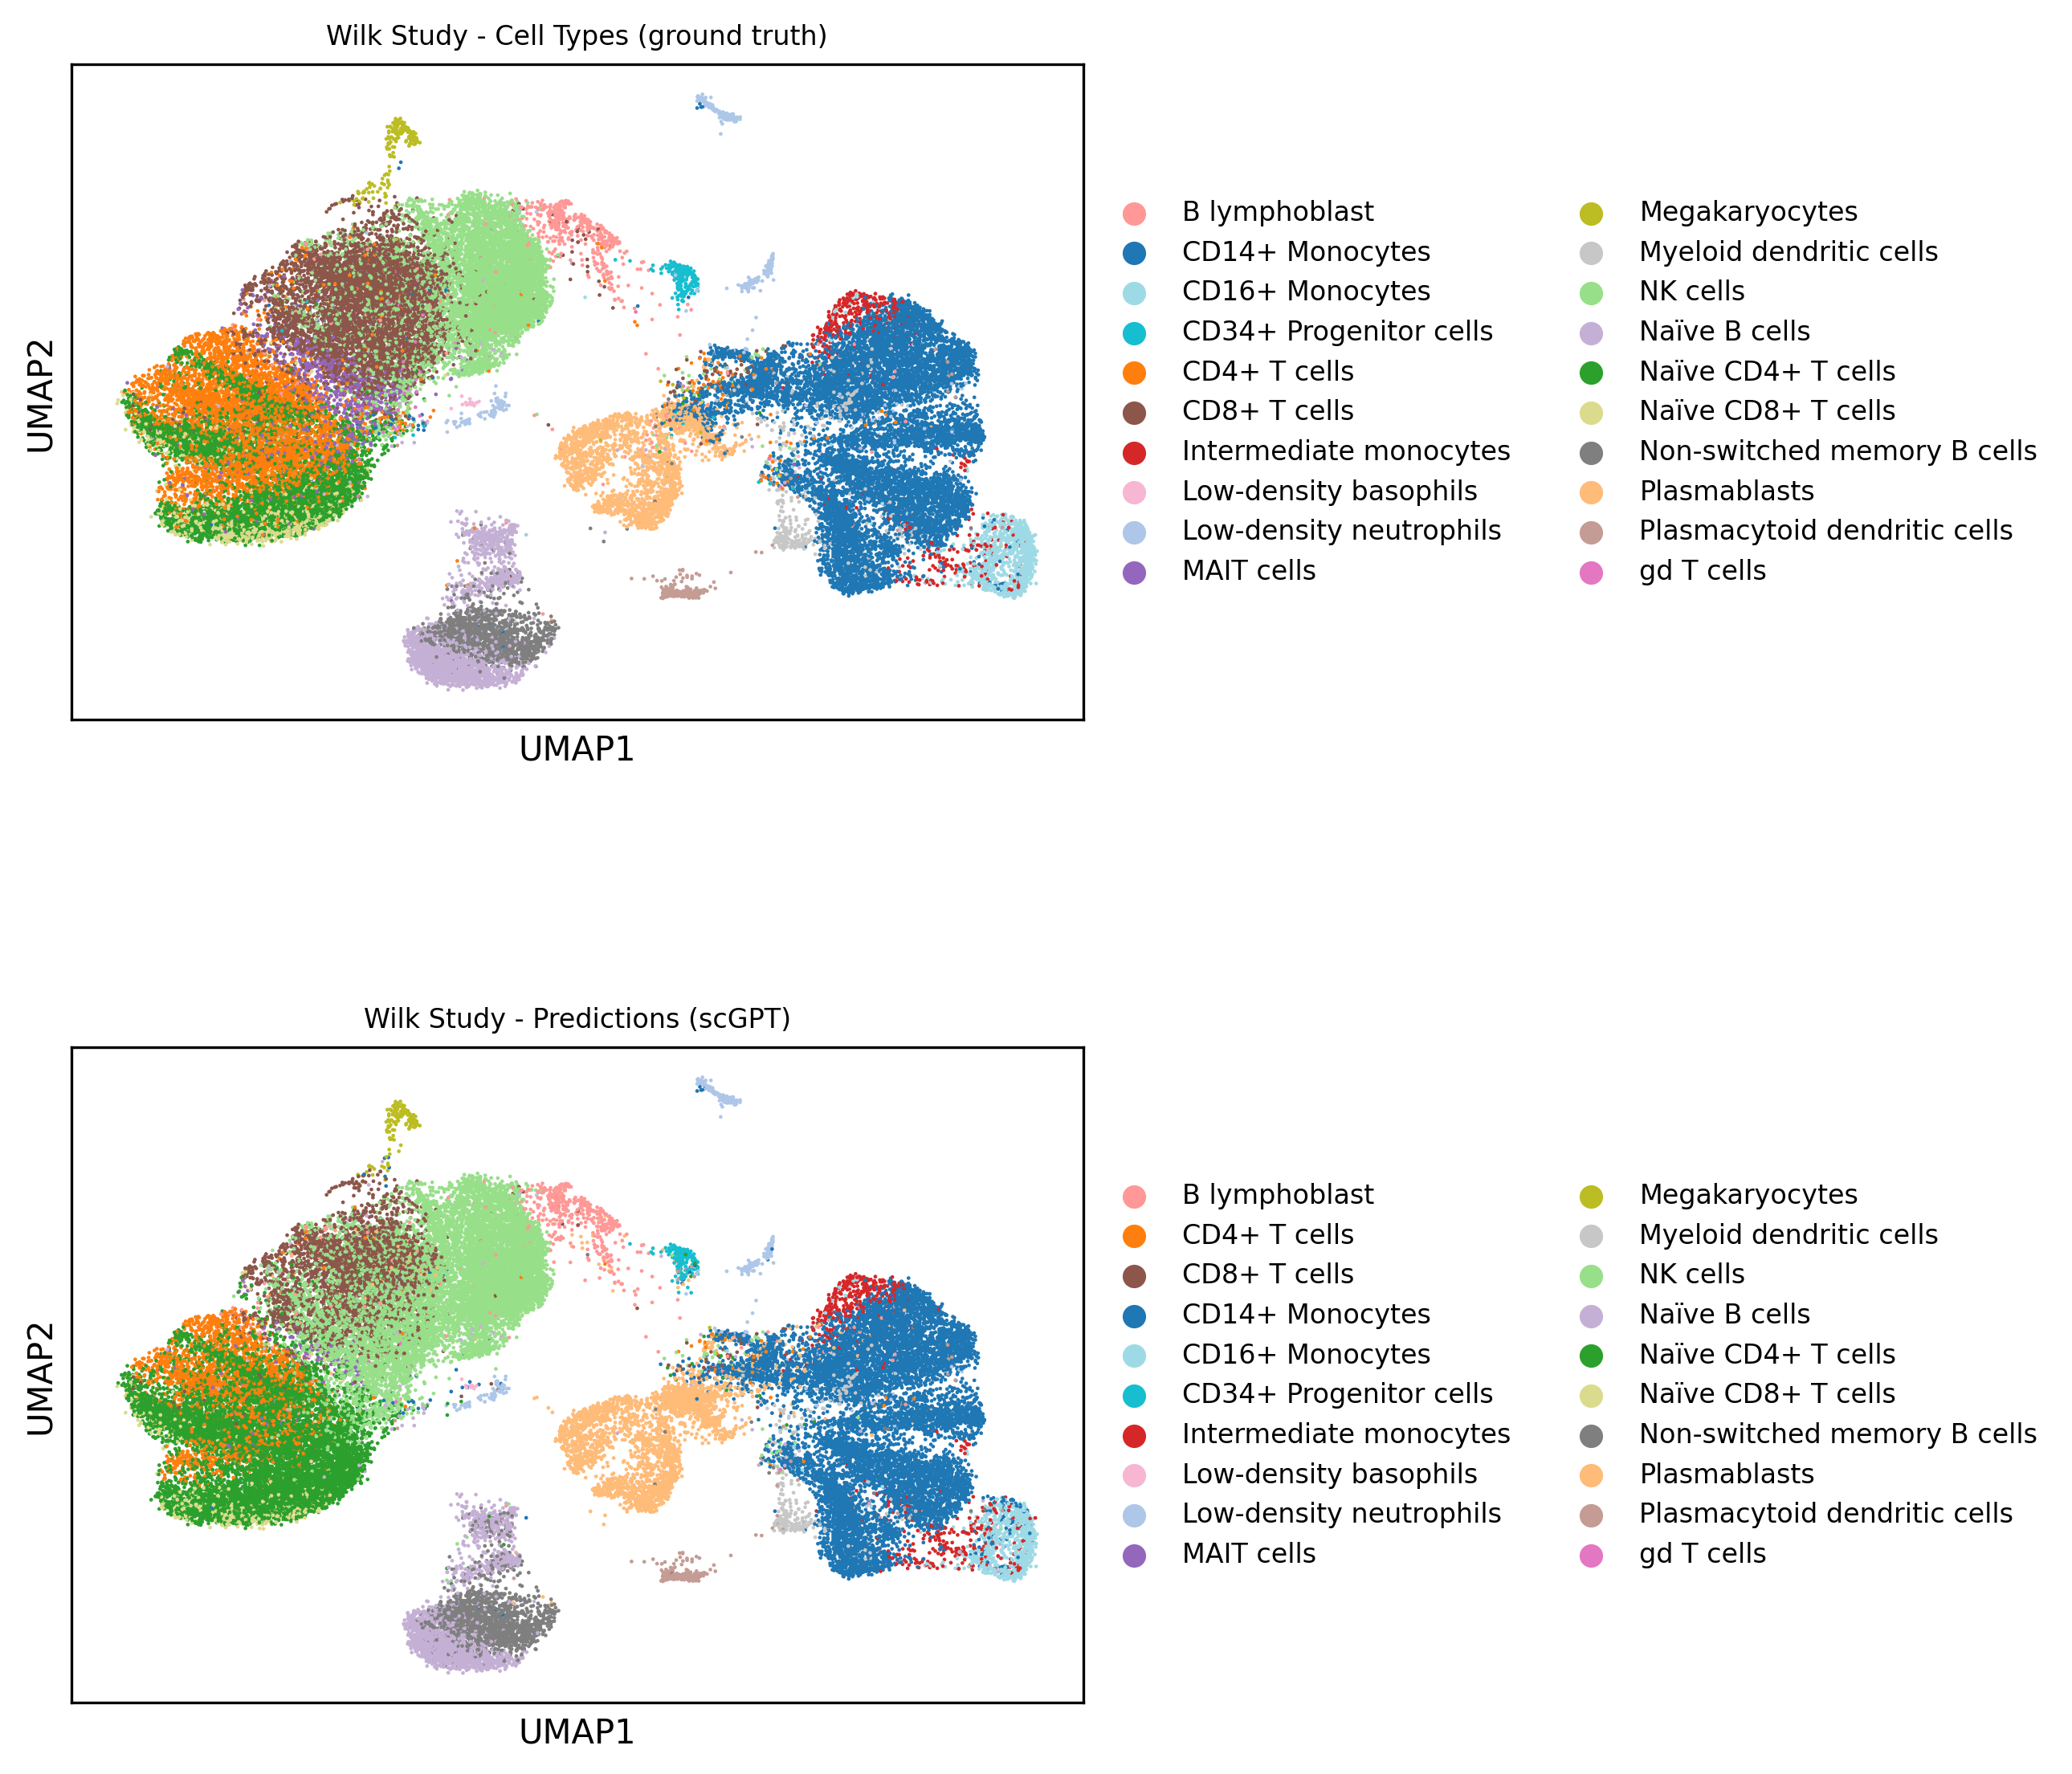

In [40]:
# Generate a palette with 20 distinct colors
palette_ = sns.color_palette("tab20", 20)
palette_ = {c: palette_[i % 20] for i, c in enumerate(celltypes)}

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(6, 8), dpi=300)  # Increased size for better layout

# First UMAP plot
sc.pl.umap(
    wilkData,
    color="celltype",
    palette=palette_,
    ax=axes[0],  # Use the first subplot
    show=False,
    size=5,
    legend_fontsize=8,  # Decrease legend font size
)
axes[0].set_title("Wilk Study - Cell Types (ground truth)", fontsize=8)  # Reduced text size
axes[0].tick_params(axis="both", which="major", labelsize=5)  # Smaller tick labels

# Second UMAP plot
sc.pl.umap(
    wilkData,
    color="predictions",
    palette=palette_,
    ax=axes[1],  # Use the second subplot
    show=False,
    size=5,
    legend_fontsize=8,  # Decrease legend font size
)
axes[1].set_title("Wilk Study - Predictions (scGPT)", fontsize=8)  # Reduced text size
axes[1].tick_params(axis="both", which="major", labelsize=5)  # Smaller tick labels

# Adjust spacing
fig.subplots_adjust(top=0.95, bottom=0.1, left=0.15, right=0.85, hspace=0.5)  # Adjust margins and space between plots

plt.show()

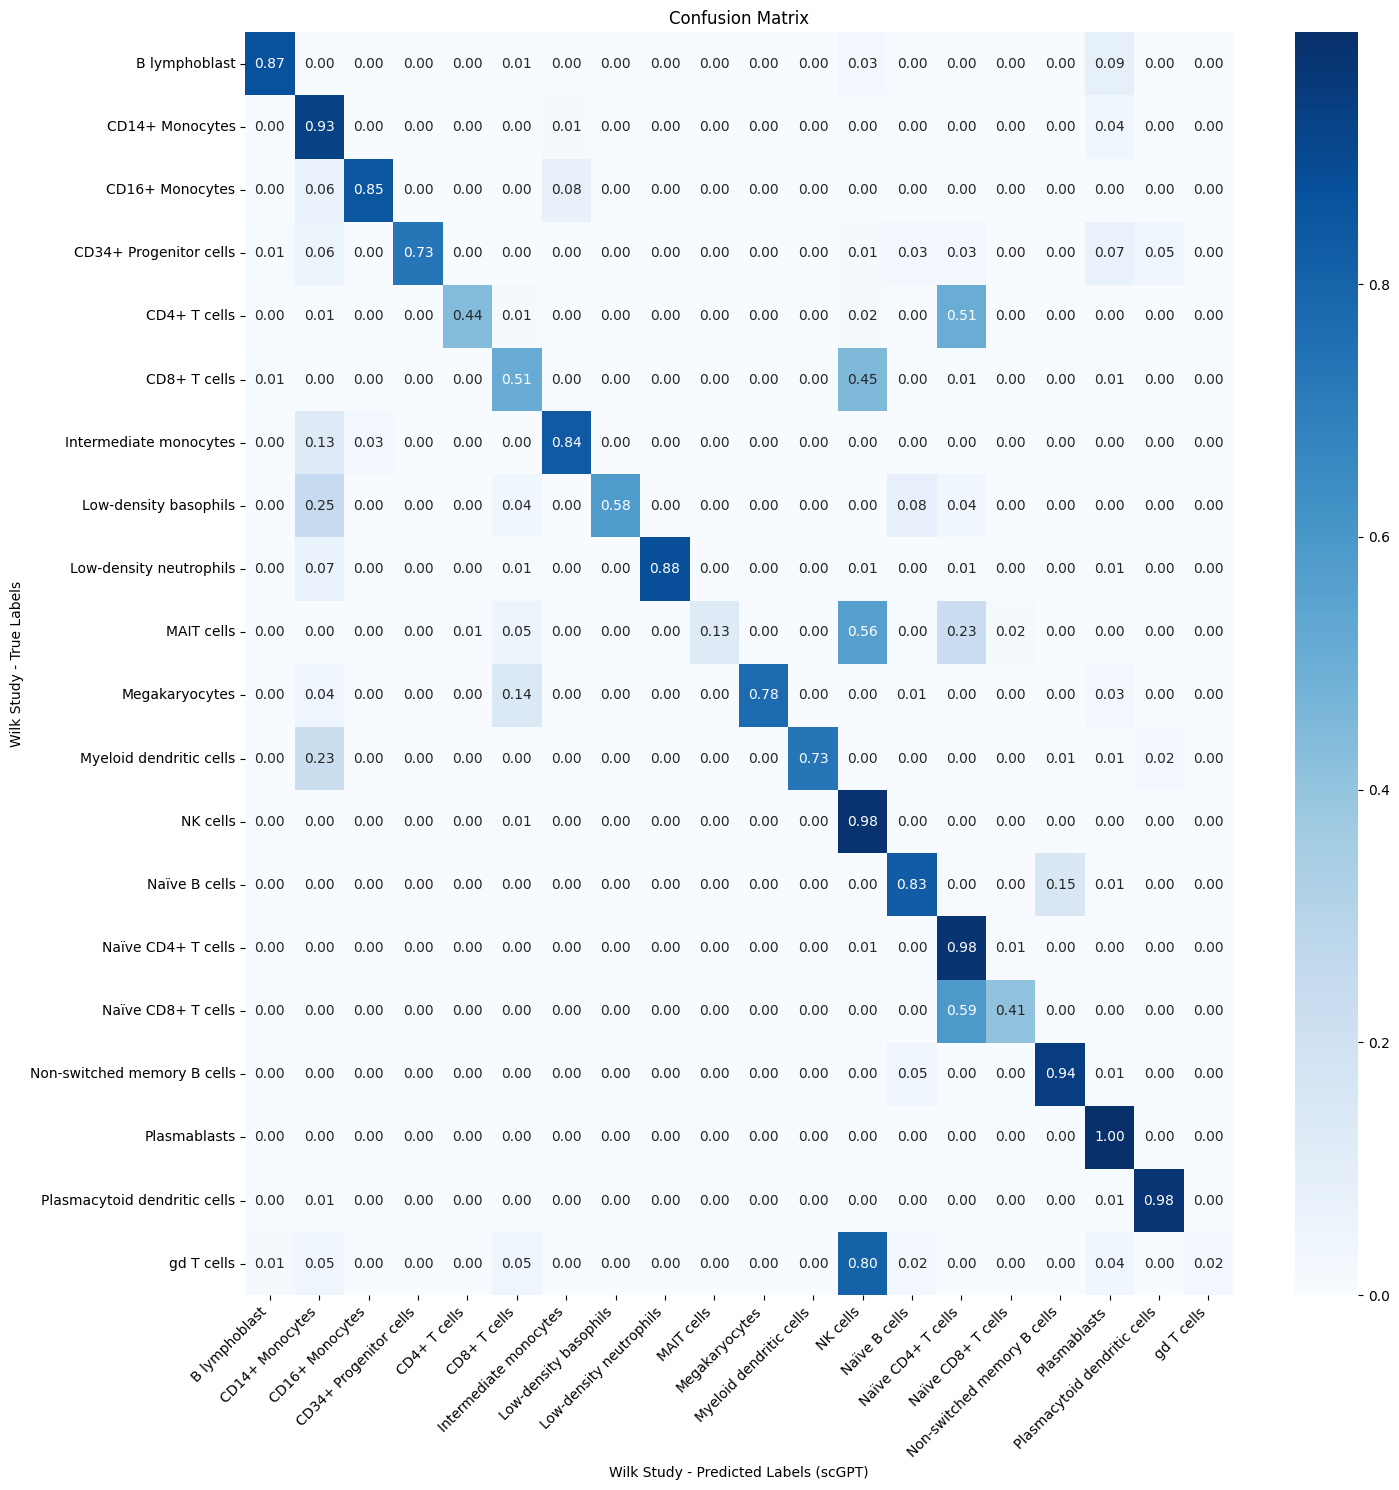

In [48]:
# Extract labels and predictions
labels = wilkData.obs["celltype"].astype(str).values  # Ensure these are strings
predictions = wilkData.obs["predictions"].astype(str).values

# Create a sorted list of unique cell types for consistent ordering
celltypes = sorted(list(set(labels) | set(predictions)))

# Compute the confusion matrix
cm = confusion_matrix(labels, predictions, labels=celltypes)

# Normalize the confusion matrix row-wise
cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True)

# Convert the confusion matrix to a DataFrame for easy labeling
cm_df = pd.DataFrame(cm_normalized, index=celltypes, columns=celltypes)

# Plot the confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm_df, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Wilk Study - Predicted Labels (scGPT)")
plt.ylabel("Wilk Study - True Labels")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

/tmp/ipykernel_506253/1251560165.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_counts.index, y=labels_counts.values, ax=axes[0], palette='Blues_d')
/tmp/ipykernel_506253/1251560165.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=predictions_counts.index, y=predictions_counts.values, ax=axes[1], palette='Oranges_d')


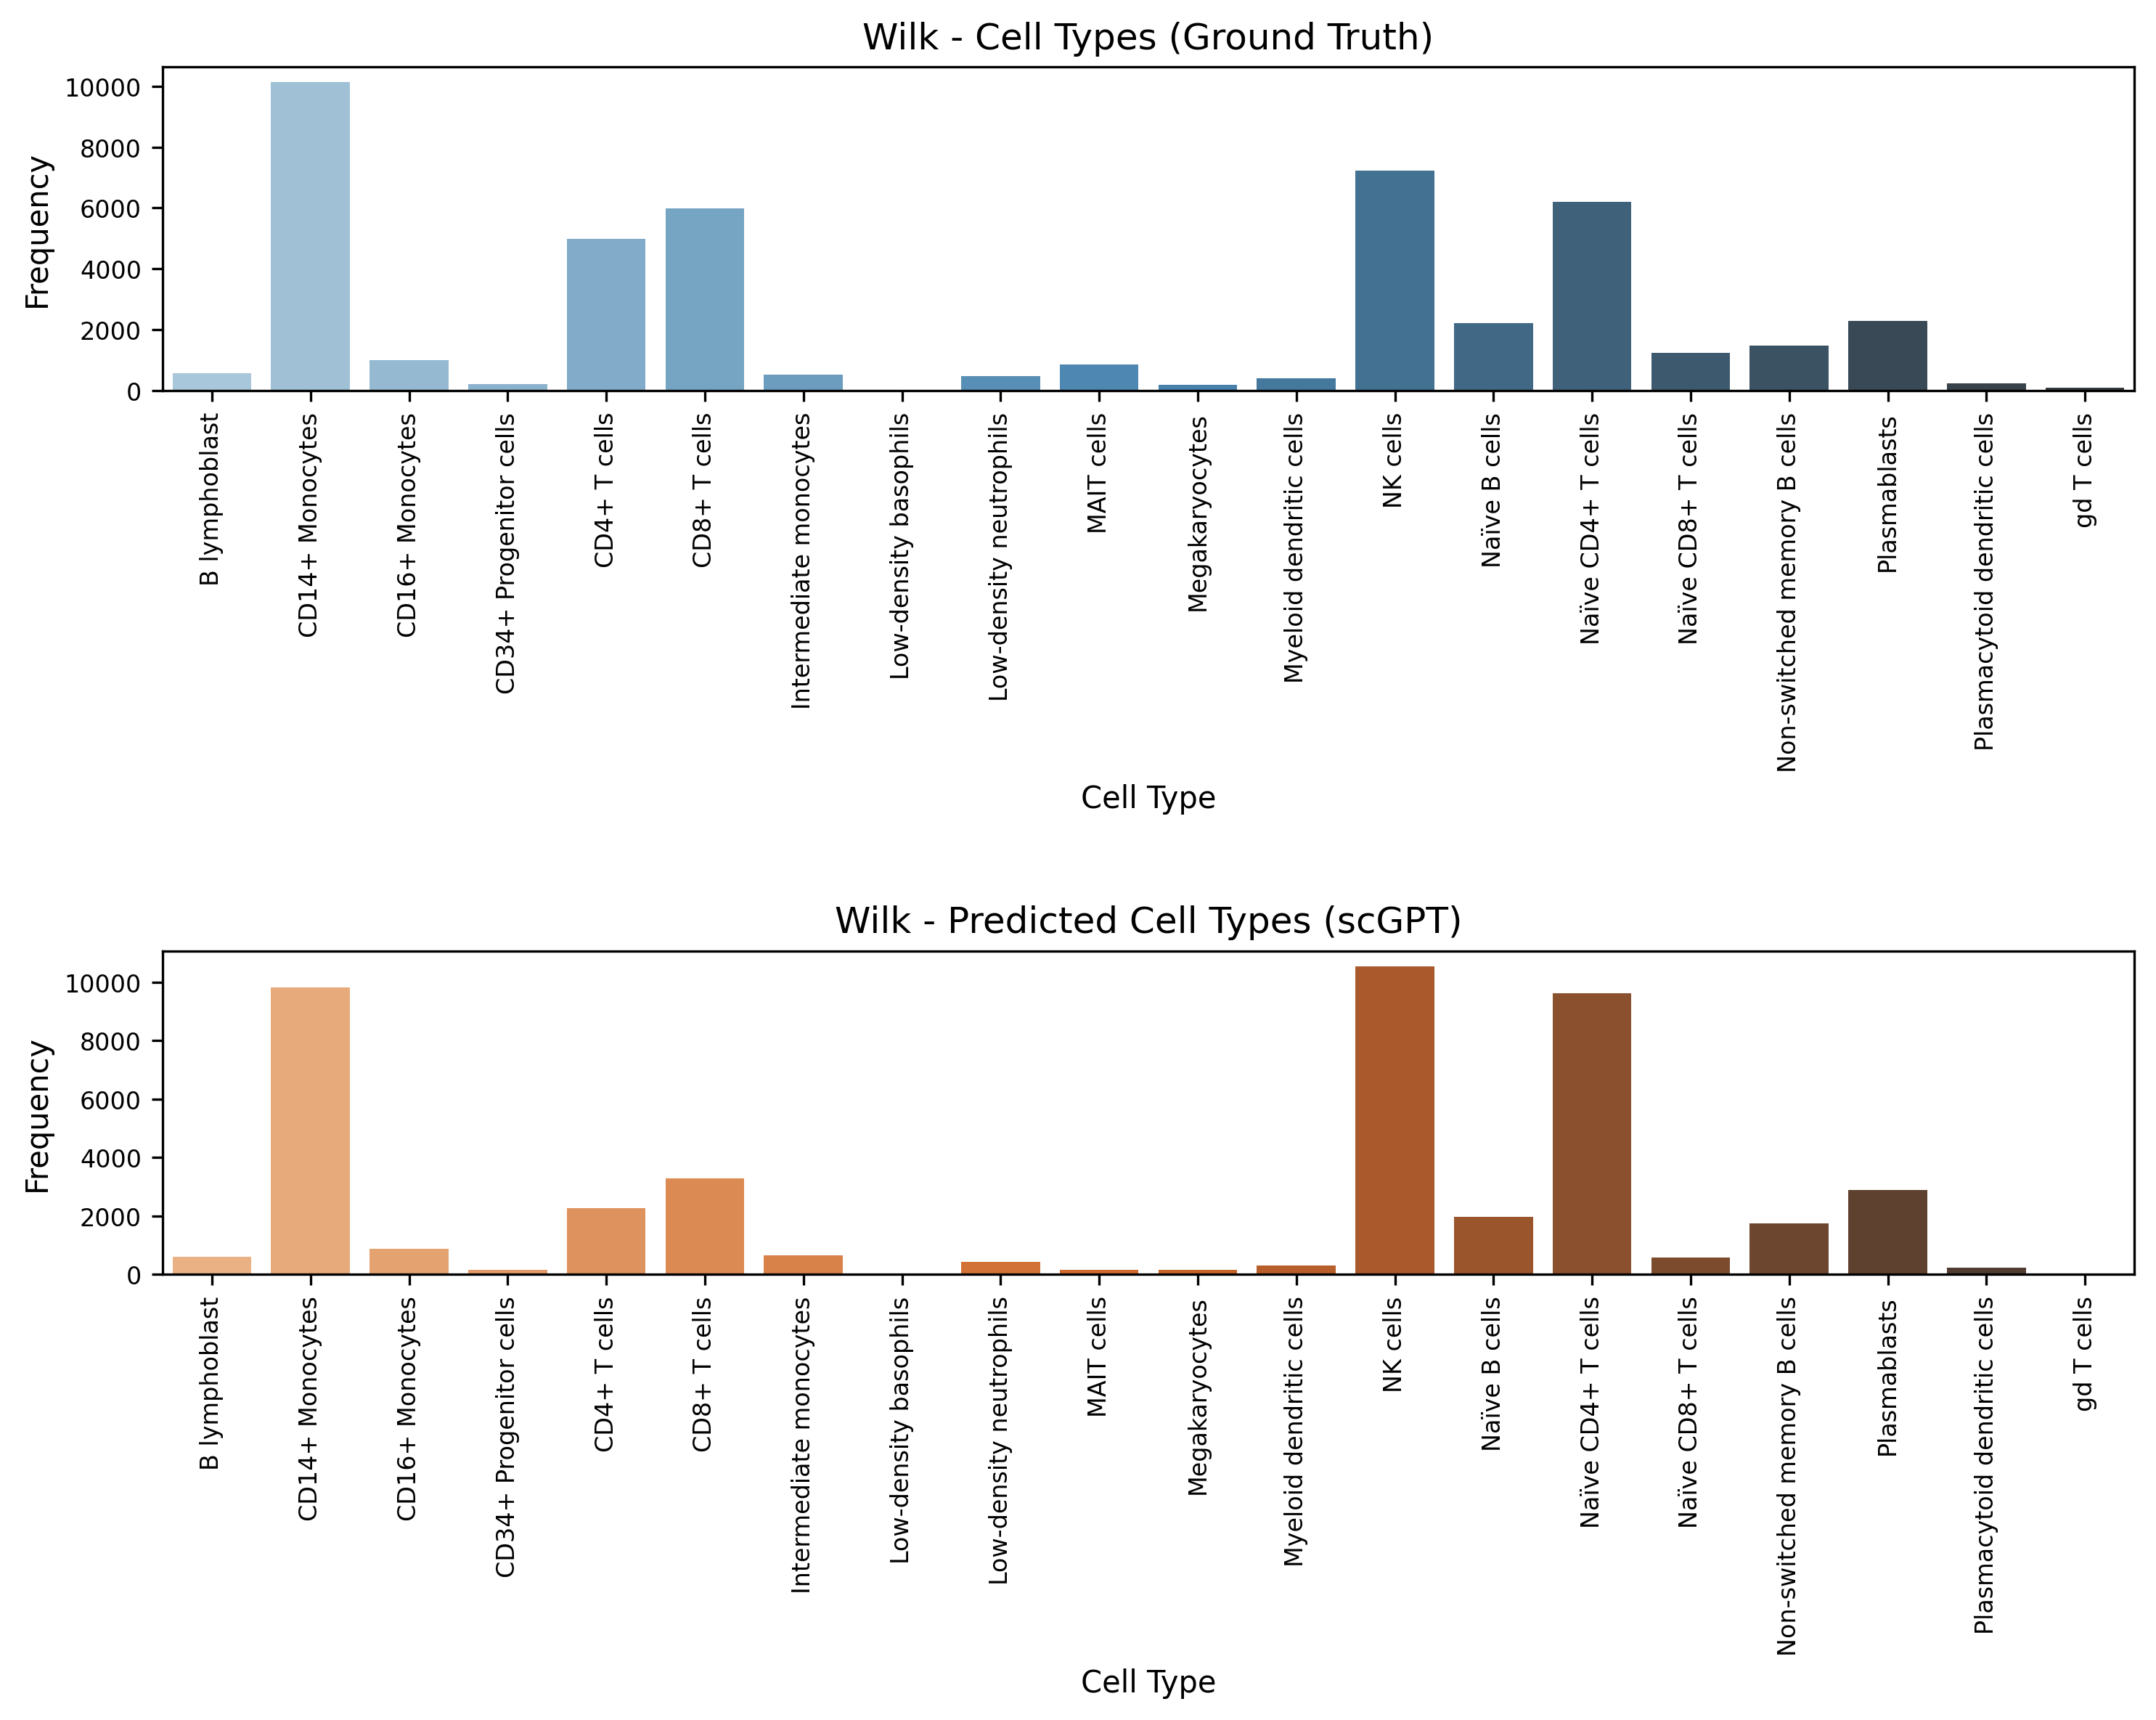

In [53]:
# Convert to DataFrames for easier plotting
labels_df = pd.DataFrame(labels, columns=['Cell Type'])
predictions_df = pd.DataFrame(predictions, columns=['Cell Type'])

# Count frequencies for ground truth and predictions
labels_counts = labels_df['Cell Type'].value_counts().sort_index()
predictions_counts = predictions_df['Cell Type'].value_counts().sort_index()

# Create a figure with two subplots (one below the other)
fig, axes = plt.subplots(2, 1, figsize=(10, 8), dpi=300)

# Ground truth plot
sns.barplot(x=labels_counts.index, y=labels_counts.values, ax=axes[0], palette='Blues_d')
axes[0].set_title("Wilk - Cell Types (Ground Truth)", fontsize=12)
axes[0].set_xlabel("Cell Type", fontsize=10)
axes[0].set_ylabel("Frequency", fontsize=10)
axes[0].tick_params(axis='x', rotation=90, labelsize=8)
axes[0].tick_params(axis='y', labelsize=8)

# Predictions plot
sns.barplot(x=predictions_counts.index, y=predictions_counts.values, ax=axes[1], palette='Oranges_d')
axes[1].set_title("Wilk - Predicted Cell Types (scGPT)", fontsize=12)
axes[1].set_xlabel("Cell Type", fontsize=10)
axes[1].set_ylabel("Frequency", fontsize=10)
axes[1].tick_params(axis='x', rotation=90, labelsize=8)
axes[1].tick_params(axis='y', labelsize=8)

# Adjust layout for better spacing between subplots
plt.tight_layout(h_pad=3)  # h_pad adjusts vertical spacing
plt.show()